In [3]:
# baseline model for the dogs vs cats dataset
import os
import sys
from matplotlib import pyplot

from os import listdir
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.image import imread

# Loading Images Data
## **V**ase vs **J**acket Classification

In [14]:
train_dir = r"./data/train/"
test_dir = r"./data/test/"

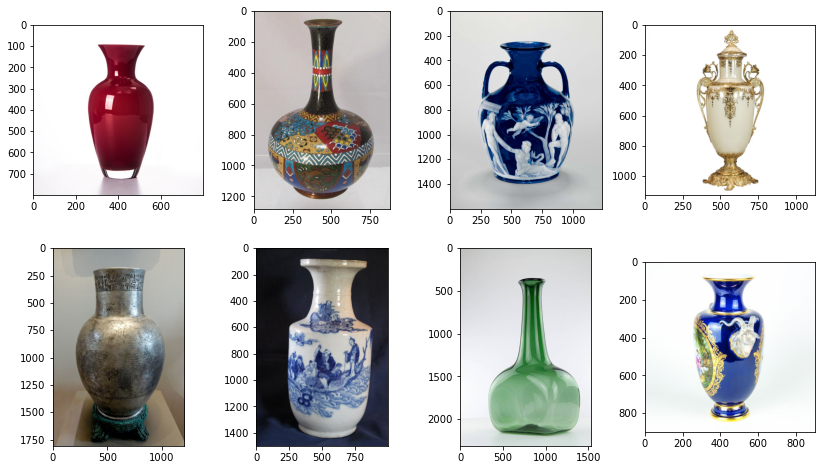

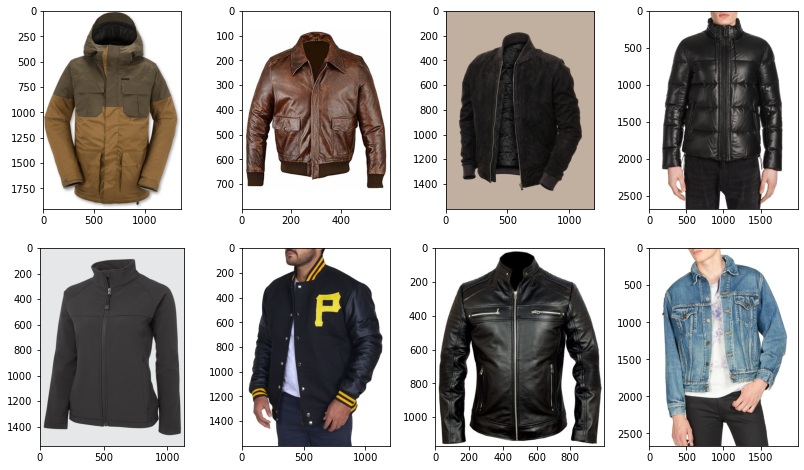

In [19]:
# To plot the dataset
# VASE vs JACKET

folder = train_dir + "vase/"
lis = listdir(folder)
pyplot.figure(figsize=(14,8))
for i in range(8):
	pyplot.subplot(240 + 1 + i)
	filename = folder + lis[-i]
	image = imread(filename)
	pyplot.imshow(image)
pyplot.show()

folder = train_dir + "jacket/"
lis = listdir(folder)
pyplot.figure(figsize=(14,8))
for i in range(8):
	pyplot.subplot(240 + 1 + i)
	filename = folder + lis[i]
	image = imread(filename)
	pyplot.imshow(image)
pyplot.show()


In [48]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	pyplot.figure(figsize=(10,8))
    # plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	pyplot.legend()
    # plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['acc'], color='blue', label='train')
	pyplot.plot(history.history['val_acc'], color='orange', label='test')
	pyplot.legend()
	filename = CNN_metric
	pyplot.savefig(filename + '_plot.png')
	pyplot.show()
	pyplot.close()

In [34]:
# run the test harness for evaluating a model
data_augmentation = False
def run_test_harness(data_augmentation = False):
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    if (data_augmentation):
        train_datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
        train_it = train_datagen.flow_from_directory(train_dir, class_mode='binary', batch_size=64, target_size=(200, 200))
    else:
        train_it = datagen.flow_from_directory(train_dir, class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory(test_dir, class_mode='binary', batch_size=64, target_size=(200, 200))
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=25, verbose=0)
    # evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
    print("Accuracy ",'%.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Accuracy  95.000


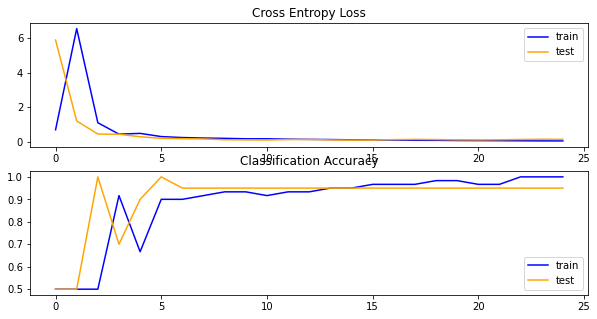

In [43]:
# Running the test harness without Data Augmentation
run_test_harness()

Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Accuracy  95.000


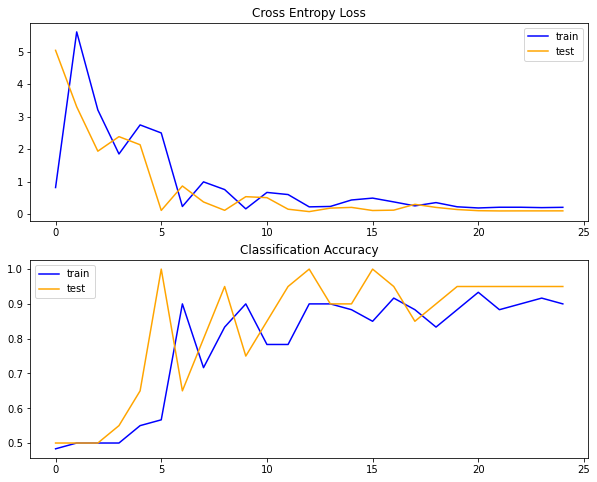

In [50]:
# Running the test harness with Data Augmentation
run_test_harness(True)

In [52]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
def define_model_vgg16():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [55]:
def run_test_harness_vgg16():
	# define model
	model = define_model_vgg16()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory(train_dir, class_mode='binary', batch_size=64, target_size=(224, 224))
	test_it = datagen.flow_from_directory(test_dir, class_mode='binary', batch_size=64, target_size=(224, 224))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print("Accuracy with Transfer Learning",': %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Epoch 1/10
Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 7.2478 - acc: 0.5667 - val_loss: 11.2750 - val_acc: 0.5000
Epoch 2/10
Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 12.7896 - acc: 0.5000 - val_loss: 1.3402e-17 - val_acc: 1.0000
Epoch 3/10
Epoch 1/10
1/1 [==============================] - 11s 11s/step - loss: 9.1059e-28 - acc: 1.0000 - val_loss: 3.4051e-18 - val_acc: 1.0000
Epoch 4/10
Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 4.4657e-18 - val_acc: 1.0000
Epoch 5/10
Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 1.7250e-17 - val_acc: 1.0000
Epoch 6/10
Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 7.9286e-17 - val_acc: 1.0000
Epoch 7/10
Epoch 1/10
1/1 [===============

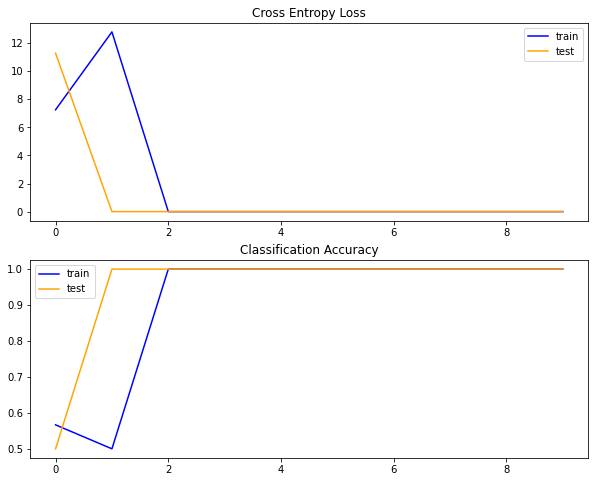

In [56]:
run_test_harness_vgg16()